In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import shap
import re
from datetime import datetime as dt
from tqdm import tqdm
import scipy.stats as ss
import getpass
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import recall_score, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

%matplotlib inline
shap.initjs()

# Extract

In [2]:
# key = getpass.getpass()

In [3]:
# tmdb_api_url = 'https://api.themoviedb.org/3/'

# def get_genres(api_key=key):
#     api_key = f'api_key={api_key}'
#     tmdb_api_url = 'https://api.themoviedb.org/3/'
    
#     get_genres = 'genre/movie/list'
#     response = requests.get(tmdb_api_url + '?'.join([get_genres, api_key]))
#     genres = response.json()['genres']
    
#     genres_ls = [d['name'] for d in genres]
#     genres_ls.append('Foreign')
#     genres_ls = sorted(genres_ls)
#     n_genres = len(genres_ls)
    
#     return {'n_genres': n_genres, 'genres_ls': genres_ls}

# def get_details_and_reviews(api_key=key, goodness_thresh=80, **kwargs):
#     api_key = f'api_key={api_key}'
#     n_genres = kwargs['n_genres']
#     genrs_
    
#     tmdb = pd.read_csv('data/tmdb_5000_movies.csv')

#     tmdb['goodness'] = tmdb['vote_average'] * tmdb['vote_count'] / tmdb['vote_count'].max()
#     # threshold -> 80th percentile (default)
#     threshold = np.around(np.percentile(tmdb['goodness'], goodness_thresh), 2)
#     # encoding 1 <-> goodness >= threshold
#     tmdb['goodness_enc'] = 0
#     tmdb.loc[tmdb['goodness'] >= threshold, 'goodness_enc'] = 1
    
#     cols_to_keep = ['id', 'title', 'status', 'release_date', 'budget', 'revenue',
#                     'original_language', 'runtime', 'popularity', 'goodness_enc']
#     # keeping only movies that have a positive vote_count
#     tmdb_clean = tmdb.loc[tmdb['vote_count'] > 0, cols_to_keep].dropna(axis=0).reset_index(drop=True)
    
#     reviews = pd.Series(name='reviews')
#     df_genres = pd.DataFrame(columns=genres_ls)
    
#     for i, movie_id in enumerate(tqdm(tmdb_clean['id'])):
#         get_reviews = f'movie/{movie_id}/reviews'
#         response_reviews = requests.get(tmdb_api_url + '?'.join([get_reviews, api_key]))
#         if response_reviews.status_code == 200:
#             reviews.loc[i] = [d['content'] for d in response_reviews.json()['results']]
#         else:
#             reviews.loc[i] = []

#         df_genres.loc[i] = np.zeros(n_genres, dtype=int)
#         movie_genres = re.findall(r'\"name\": \"([A-Za-z\s]+)\"', tmdb['genres'][i])
#         df_genres.loc[i, movie_genres] = 1
        
#     df = pd.concat([tmdb_clean, df_genres, reviews], axis=1).sort_values('id').reset_index(drop=True)

#     # turning dtype of release_date to datetime and extracting only the year
#     df['release_date'] = pd.to_datetime(df['release_date'], infer_datetime_format=True).dt.year
#     df = df.rename(columns={'release_date': 'release_year'})

#     # keeping only movies that have been released
#     df = df[df['status'] == 'Released'].reset_index(drop=True)
#     details = df.drop(['status', 'reviews', 'Foreign', 'TV Movie'], axis=1)
#     details.to_csv('data/details.csv', index=False)
    
#     reviews = df[['id', 'title', 'reviews', 'goodness_enc']]
#     reviews.to_csv('data/reviews.csv', index=False)

# Load and Clean

In [4]:
def clean_details(df):
    # binning low count languages (<10) in category called 'other'
    lang_counts = df['original_language'].value_counts()
    df.loc[df['original_language'].isin(lang_counts[lang_counts < 10].index), 'original_language'] = 'other'
    
    # dropping features that are irrelevant for prediction
    df.drop(['id', 'title'], axis=1, inplace=True)
    
    return df

# def clean_reviews(df):
#     return df

def get_data(csv_file, target='goodness_enc'):
    df = pd.read_csv(f'data/{csv_file}.csv')
    
    df_clean = clean_details(df)
    X = df_clean.drop(target, axis=1)
    X = pd.get_dummies(X, drop_first=True)
    y = df_clean[target]
    
    return {'X': X, 'y': y}

# Transform

In [5]:
def split_func(test_size=.2, **kwargs):
    X = kwargs['X']
    y = kwargs['y']
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=test_size,
                                                        stratify=y)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split_func(**get_data(csv_file='details'))

In [7]:
# pipeline that transforms X
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('poly', PolynomialFeatures(degree=2, interaction_only=True))])
    
X_train_new = pipeline.fit_transform(X_train)
X_test_new = pipeline.fit_transform(X_test)

# Models

## Logistic Regression

In [8]:
logr_clf = LogisticRegression(random_state=42,
                              tol=.001,
                              n_jobs=-1)

logr_params = {'penalty': ['l1', 'l2', 'elasticnet'],
               'C': ss.uniform(0, 100),
               'l1_ratio': ss.uniform(0, 1)}

## k Nearest Neighbors  (kNN)

In [9]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

knn_params = {'n_neighbors': range(3,100,2),
              'weights': ['uniform', 'distance']}

## Support Vector Machine (SVM)

In [10]:
svm_clf = SVC(probability=True,
              tol=.01,
              random_state=42)

svm_params = {'C': ss.uniform(0, 100),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [1, 2, 3],
              'coef0': ss.uniform(0, 10)}

## Random Forest (RF)

In [11]:
rf_clf = RandomForestClassifier(n_jobs=-1,
                                random_state=42)

rf_params = {'n_estimators': range(1,500),
             'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4],
             'max_features': range(1, X_train.shape[1]),
             'max_samples': range(1, X_train.shape[0])}

## Light Gradient Boosting Machine (LGBM)

In [12]:
lgbm_clf = LGBMClassifier(random_state=42,
                          n_jobs=-1)

lgbm_params = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
               'max_depth': [1, 2, 3, 4],
               'learning_rate': ss.uniform(0, 1),
               'n_estimators': range(1,500),
               'subsample': ss.uniform(0.001, 1),
               'subsample_freq': range(1,101),
               'colsample_bytree': ss.uniform(0.001, 1),
               'reg_alpha': ss.uniform(0, 1),
               'reg_lambda': ss.uniform(0, 1)}

## Extreme Gradient Boosting (XGBoost)

In [13]:
xgb_clf = XGBClassifier(random_state=42)

xgb_params = {'max_depth': [1, 2, 3, 4],
              'learning_rate': ss.uniform(0, 1),
              'boster': ['gbtree', 'gblinear', 'dart'],
              'subsample': ss.uniform(0.001, 1),
              'colsample_bytree': ss.uniform(0.001, 1),
              'colsample_bylevel': ss.uniform(0.001, 1),
              'colsample_bynode': ss.uniform(0.001, 1),
              'reg_alpha': ss.uniform(0, 1),
              'reg_lambda': ss.uniform(0, 1),
              'num_parallel_tree': range(1,500)}

## Multilayer Perceptron (MLP)

In [14]:
mlp_clf = MLPClassifier(early_stopping=True,
                        random_state=42)

mlp_params = {'hidden_layer_sizes': range(1,500),
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'alpha': ss.uniform(0, 1),
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'learning_rate_init': ss.uniform(0, 1),
              'momentum': ss.uniform(0, 1),
              'beta_1': ss.uniform(0, 0.999),
              'beta_2': ss.uniform(0, 0.999)}

# Fitting the Models

In [15]:
models = {'logr': [logr_clf, logr_params],
          'knn': [knn_clf, knn_params],
          'svm': [svm_clf, svm_params],
          'rf': [rf_clf, rf_params],
          'lgbm': [lgbm_clf, lgbm_params],
          'xgb': [xgb_clf, xgb_params],
          'mlp': [mlp_clf, mlp_params]}

In [16]:
best_estimators = {}
for m in tqdm(models.keys()):
    rscv = RandomizedSearchCV(models[m][0],
                              models[m][1],
                              scoring='recall',
                              n_iter=200,
                              n_jobs=-1,
                              cv=3,
                              verbose=True)

    rscv.fit(X_train_new, y_train)
    best_estimators[m] = rscv.best_estimator_

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   35.3s finished
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
 14%|█▍        | 1/7 [00:36<03:41, 36.93s/it]The total space of parameters 98 is smaller than n_iter=200. Running 98 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:  4.8min finished
 29%|██▊       | 2/7 [05:24<09:19, 112.00s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 66.6min finished
 43%|████▎     | 3/7 [1:12:36<1:25:52, 1288.17s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.5min finished
 57%|█████▋    | 4/7 [1:14:06<46:26, 928.81s/it]   [Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.6min finished
 71%|███████▏  | 5/7 [1:16:44<23:15, 697.55s/it]

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 202.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 283.3min finished
 86%|████████▌ | 6/7 [6:03:05<1:34:02, 5642.61s/it]

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.5min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 31.7min finished
100%|██████████| 7/7 [6:34:50<00:00, 3384.29s/it]  


## Stacking

In [17]:
estimators = [('knn', best_estimators['knn']),
              ('logr', best_estimators['logr']),
              ('svm', best_estimators['svm']),
              ('rf', best_estimators['rf']),
              ('mlp', best_estimators['mlp']),
              ('xgb', best_estimators['xgb']),
              ('lgbm', best_estimators['lgbm'])]

blender = StackingClassifier(estimators, cv=3)
X_train_stack = blender.fit_transform(X_train_new, y_train)
X_test_stack = blender.transform(X_test_new)

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


# Evaluation

## Recall Scores (threshold = 0.5)

In [18]:
recall_scores = {}
recall_scores['train recall'] = []
recall_scores['val recall'] = []
recall_scores['test recall'] = []

for m in best_estimators.keys(): 
    best = best_estimators[m]
    results = cross_validate(best,
                             X_train_new,
                             y_train,
                             cv=3,
                             scoring='recall',
                             return_train_score=True)

    train_score = results['train_score'].mean()
    val_score = results['test_score'].mean()
    test_score = cross_val_score(best,
                                 X_test_new,
                                 y_test,
                                 cv=3,
                                 scoring='recall',
                                 n_jobs=-1).mean()

    recall_scores['train recall'].append(round(100 * train_score, 4))
    recall_scores['val recall'].append(round(100 * val_score, 4))
    recall_scores['test recall'].append(round(100 * test_score, 4))

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


In [19]:
best_estimators['stack'] = blender

results = cross_validate(blender,
                         X_train_new,
                         y_train,
                         cv=3,
                         scoring='recall',
                         return_train_score=True)

train_score = results['train_score'].mean()
val_score = results['test_score'].mean()
test_score = cross_val_score(blender,
                             X_test_new,
                             y_test,
                             cv=3,
                             scoring='recall',
                             n_jobs=-1).mean()

recall_scores['train recall'].append(round(100 * train_score, 4))
recall_scores['val recall'].append(round(100 * val_score, 4))
recall_scores['test recall'].append(round(100 * test_score, 4))

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


In [20]:
recall_scores_df = pd.DataFrame(recall_scores, index=list(best_estimators.keys()))
recall_scores_df

,train recall,val recall,test recall
logr,90.8095,77.5781,67.7083
knn,100.0000,49.8111,38.0208
svm,92.8299,77.7083,68.2292
rf,82.1384,81.7509,85.4167
lgbm,87.3564,86.8290,85.4167
xgb,88.0054,84.8800,82.2917
mlp,98.1097,77.8401,67.1875
stack,88.0064,83.3160,84.3750


## Learning Curves

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


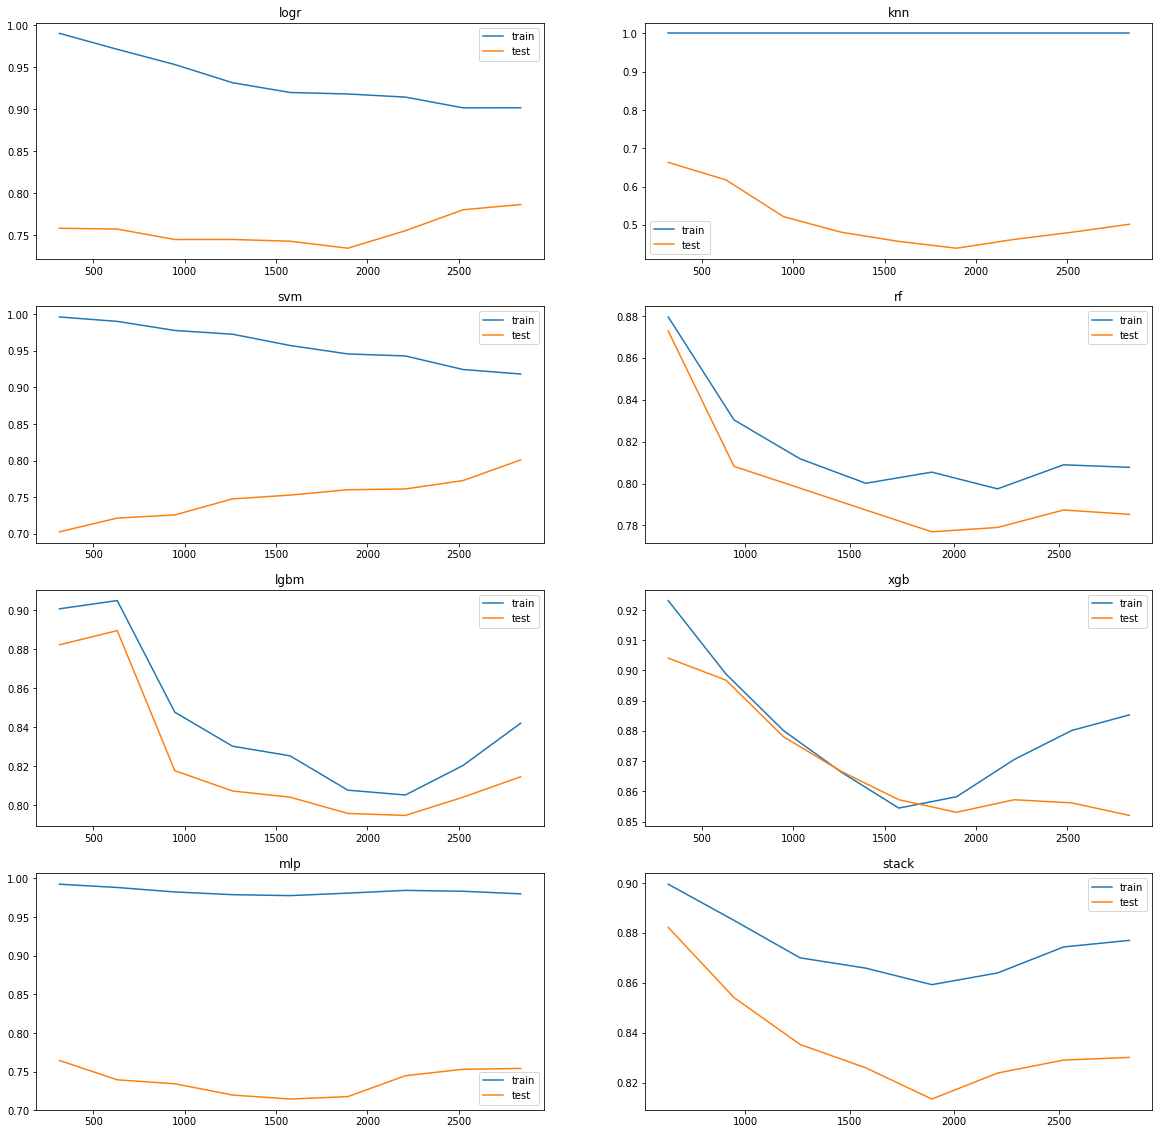

In [23]:
X = pipeline.fit_transform(get_data('details')['X'])
y = get_data('details')['y']

fig, ax = plt.subplots(4, 2, figsize=(20,20))
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1],
        ax[2,0], ax[2,1], ax[3,0], ax[3,1]]

for i, m in enumerate(best_estimators.keys()):
    train_sizes, train_scores, test_scores = learning_curve(best_estimators[m],
                                                            X,
                                                            y,
                                                            train_sizes=np.linspace(0.1, 0.9, 9),
                                                            cv=3,
                                                            scoring='recall',
                                                            n_jobs=-1)

    sns.lineplot(train_sizes, train_scores.mean(axis=1), markers=True, ax=axes[i]).set_title(m)
    sns.lineplot(train_sizes, test_scores.mean(axis=1), markers=True, ax=axes[i])
    axes[i].legend(['train', 'test']);

## Precision-Recall Curves

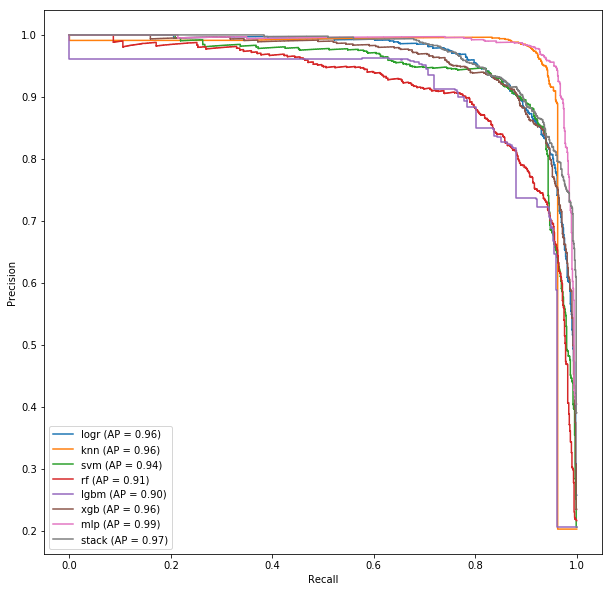

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
for m in best_estimators.keys():
    plot_precision_recall_curve(best_estimators[m], X, y, name=m, ax=ax)